In [1]:
import helper
import pennylane
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch

from torch import *
from torch import nn
from torch.utils.data import DataLoader
from IPython.display import Image

df = pd.read_csv('data_Luis.csv')
df

,Fecha,Apertura,Maximo,Minimo,Cierre,Aj_ Cierre,Volumen,Variacion,Yahoo = Investing
0,04/01/2010,32120.74023,32758.52930,32120.74023,32758.52930,32758.52930,136257800,1.99%,si
1,05/01/2010,32729.30078,33073.71094,32628.24023,32732.75977,32732.75977,165541900,-0.08%,si
2,06/01/2010,32730.41992,32922.12109,32639.43945,32830.16016,32830.16016,126000100,0.30%,si
3,07/01/2010,32830.21875,33069.78125,32670.98047,33064.57031,33064.57031,123563200,0.71%,si
4,08/01/2010,33067.57031,33080.05078,32779.66016,32892.03906,32892.03906,109516900,-0.52%,si
...,...,...,...,...,...,...,...,...,...
3266,26/12/2022,50530.62891,50712.39063,50211.37109,50273.89063,50273.89063,11411000,-0.60%,si
3267,27/12/2022,50305.69922,50838.64844,50277.12109,50440.01953,50440.01953,54768700,0.33%,si
3268,28/12/2022,50432.78125,50491.08984,49605.37891,49648.21094,49648.21094,73263800,-1.57%,si
3269,29/12/2022,49708.67188,50209.78906,49461.51953,49517.85938,49517.85938,63993800,-0.26%,si


In [2]:
target = "Cierre"

In [3]:
df = df.drop(['Fecha' ,'Yahoo = Investing','Variacion'], axis=1)
df


,Apertura,Maximo,Minimo,Cierre,Aj_ Cierre,Volumen
0,32120.74023,32758.52930,32120.74023,32758.52930,32758.52930,136257800
1,32729.30078,33073.71094,32628.24023,32732.75977,32732.75977,165541900
2,32730.41992,32922.12109,32639.43945,32830.16016,32830.16016,126000100
3,32830.21875,33069.78125,32670.98047,33064.57031,33064.57031,123563200
4,33067.57031,33080.05078,32779.66016,32892.03906,32892.03906,109516900
...,...,...,...,...,...,...
3266,50530.62891,50712.39063,50211.37109,50273.89063,50273.89063,11411000
3267,50305.69922,50838.64844,50277.12109,50440.01953,50440.01953,54768700
3268,50432.78125,50491.08984,49605.37891,49648.21094,49648.21094,73263800
3269,49708.67188,50209.78906,49461.51953,49517.85938,49517.85938,63993800


In [4]:
features = list(df.columns.difference(['Cierre','Yahoo = Investing','Variacion']))
features

['Aj_ Cierre', 'Apertura', 'Maximo', 'Minimo', 'Volumen']

In [5]:
training_percentage = 0.67
size = int(len(df) * training_percentage)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

In [6]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

## Classic prediction

In [7]:
from utils import SequenceDataset

In [8]:
torch.manual_seed(101) #Sets the seed for generating random numbers.

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 5])
Target shape: torch.Size([1])


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)

    print(f"Train loss: {avg_loss}")
    print(f"Train accuracy: {accuracy}")
    return avg_loss, accuracy


def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    accuracy = 1.0 / (avg_loss + 1e-7)
    print(f"Test loss: {avg_loss}")
    print(f"Test accuracy: {accuracy}")
    return avg_loss, accuracy

In [10]:
from utils import ShallowRegressionLSTM

In [11]:
learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
classical_loss_train = []
classical_acc_train = []
classical_loss_test = []
classical_acc_test = []
print("Untrained test\n--------")
test_loss, test_accuracy = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)
classical_acc_test.append(test_accuracy)

for ix_epoch in range(0,100):
  print(f"Epoch {ix_epoch}\n---------")
  train_loss, train_accuracy = train_model(train_loader, model, loss_function, optimizer=optimizer)
  test_loss, test_accuracy = test_model(test_loader, model, loss_function)
  classical_loss_train.append(train_loss)
  classical_acc_train.append(train_accuracy)
  classical_loss_test.append(test_loss)
  classical_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 1.1550658986492126
Test accuracy: 0.8657513953050701

Epoch 0.0
---------


C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\3338192698.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for ix_epoch in range(0,100):


Train loss: 0.28600379124126885
Train accuracy: 3.496455924637802
Test loss: 0.15040958519981665
Test accuracy: 6.648508031058754
Epoch 1.0
---------
Train loss: 0.030387466134311772
Train accuracy: 32.908196582116574
Test loss: 0.08650121227498214
Test accuracy: 11.560518259203558
Epoch 2.0
---------
Train loss: 0.013256130340354458
Train accuracy: 75.43622691556679
Test loss: 0.04719132814008339
Test accuracy: 21.190288987050625
Epoch 3.0
---------
Train loss: 0.006917872089774858
Train accuracy: 144.5510312882087
Test loss: 0.0279196416454193
Test accuracy: 35.81695033929753
Epoch 4.0
---------
Train loss: 0.004505973455176236
Train accuracy: 221.92270275826854
Test loss: 0.018860719198642042
Test accuracy: 53.01996639000701
Epoch 5.0
---------
Train loss: 0.003647058802074423
Train accuracy: 274.1860319959806
Test loss: 0.016411296206241717
Test accuracy: 60.933267799583795
Epoch 6.0
---------
Train loss: 0.0032121106431318405
Train accuracy: 311.3120872499881
Test loss: 0.01367016

In [13]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

In [14]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

           Cierre  Model forecast
0     32758.52930    32750.298828
1     32732.75977    32745.550781
2     32830.16016    32859.054688
3     33064.57031    33080.113281
4     32892.03906    32911.281250
...           ...             ...
3266  50273.89063    50271.687500
3267  50440.01953    50429.367188
3268  49648.21094    49654.281250
3269  49517.85938    49521.492188
3270  48463.85938    48451.660156

[3272 rows x 2 columns]


C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\3916468802.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,3272), df_out["Cierre"], label = "Real")
C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\3916468802.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,3272), df_out["Model forecast"], label = "LSTM Prediction")


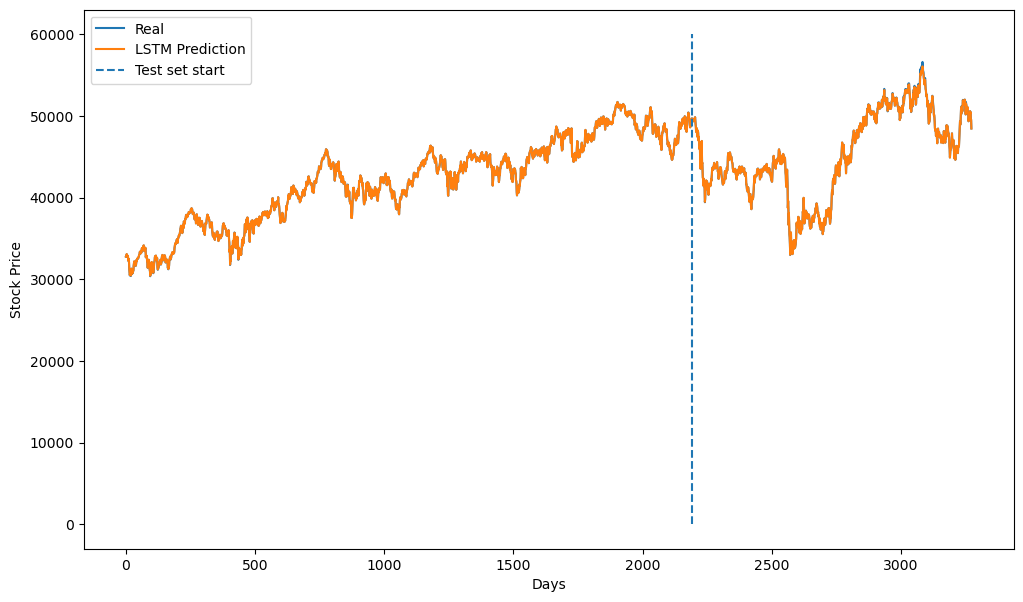

In [15]:
plt.figure(figsize=(12, 7))
plt.plot(range(1,3272), df_out["Cierre"], label = "Real")
plt.plot(range(1,3272), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 0, ymax = 60000, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

## Quantum prediction

In [16]:
from utils import QShallowRegressionLSTM

In [17]:
learning_rate = 0.05
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units, n_qubits=4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adagrad(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 4)


In [18]:
quantum_loss_train = []
quantum_acc_train = []
quantum_loss_test = []
quantum_acc_test = []
print("Untrained test\n--------")
start = time.time()
test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
end = time.time()
print("Execution time", end - start)
quantum_loss_test.append(test_loss)

for ix_epoch in range(0, 100):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss, train_accuracy = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss, test_accuracy = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_acc_train.append(train_accuracy)
    quantum_loss_test.append(test_loss)
    quantum_acc_test.append(test_accuracy)

Untrained test
--------
Test loss: 1.3969012679048556
Test accuracy: 0.7158701558864183
Execution time 147.7195761203766
Epoch 0.0
---------


C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\3932626814.py:12: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  for ix_epoch in range(0, 100):


Train loss: 0.017681026203977948
Train accuracy: 56.55748329962247
Test loss: 0.011849078255966839
Test accuracy: 84.3940379997604
Execution time 622.7633323669434
Epoch 1.0
---------
Train loss: 0.0013538395290853783
Train accuracy: 738.5854231433262
Test loss: 0.00948329932352641
Test accuracy: 105.4474208967665
Execution time 604.1335034370422
Epoch 2.0
---------
Train loss: 0.0009307776784679168
Train accuracy: 1074.2549994816163
Test loss: 0.0051500959620172995
Test accuracy: 194.16736904284826
Execution time 612.95876121521
Epoch 3.0
---------
Train loss: 0.000716552607792624
Train accuracy: 1395.3762103512329
Test loss: 0.005281566791516512
Test accuracy: 189.3341703430088
Execution time 617.1581294536591
Epoch 4.0
---------
Train loss: 0.0005730266425699429
Train accuracy: 1744.8150648099781
Test loss: 0.004355062668495001
Test accuracy: 229.61254862738951
Execution time 611.0834939479828
Epoch 5.0
---------
Train loss: 0.000492788006957197
Train accuracy: 2028.858454425411
Tes

In [19]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_loader, Qmodel).numpy()

df_out_Q = pd.concat((df_train, df_test))[[target, ystar_col_Q]]

for c in df_out_Q.columns:
    df_out_Q[c] = df_out_Q[c] * target_stdev + target_mean

print(df_out_Q)

           Cierre  Model forecast
0     32758.52930    32688.917969
1     32732.75977    32738.132812
2     32830.16016    32823.960938
3     33064.57031    33042.722656
4     32892.03906    32892.558594
...           ...             ...
3266  50273.89063    50284.035156
3267  50440.01953    50420.921875
3268  49648.21094    49678.089844
3269  49517.85938    49520.855469
3270  48463.85938    48489.468750

[3272 rows x 2 columns]


C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\1383697629.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,3272), df_out_Q["Cierre"], label = "Real")
C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\1383697629.py:3: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1,3272), df_out_Q["Model forecast"], label = "QLSTM Prediction")


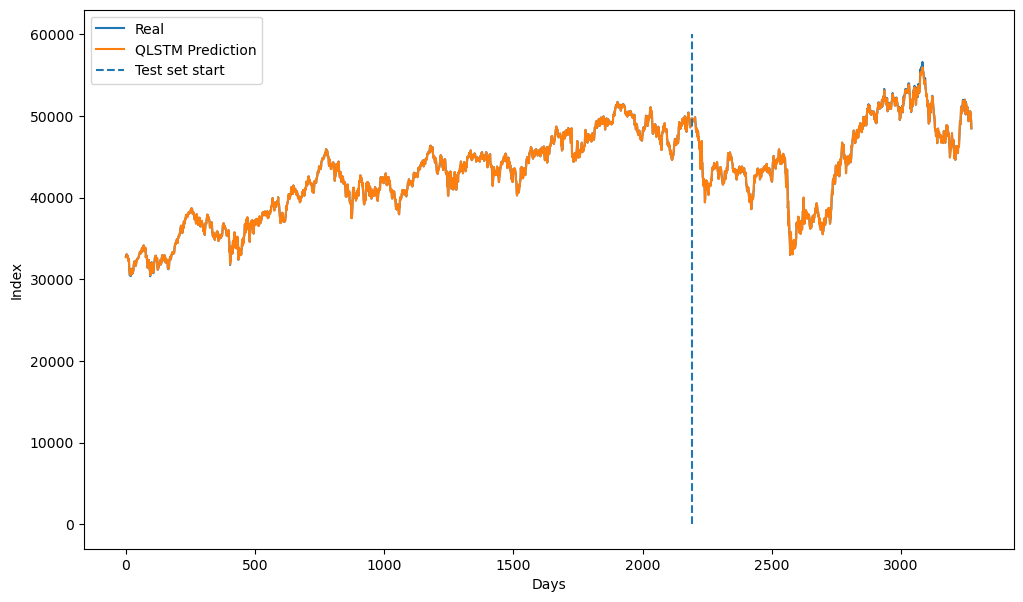

In [20]:
plt.figure(figsize=(12, 7))
plt.plot(range(1,3272), df_out_Q["Cierre"], label = "Real")
plt.plot(range(1,3272), df_out_Q["Model forecast"], label = "QLSTM Prediction")
plt.ylabel('Index')
plt.xlabel('Days')
plt.vlines(size, ymin = 0, ymax = 60000, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

In [21]:
quantum_loss_test

[1.3969012679048556,
 0.011849078255966839,
 0.00948329932352641,
 0.0051500959620172995,
 0.005281566791516512,
 0.004355062668495001,
 0.0038552000394364364,
 0.0037978998161304774,
 0.0027629188217926184,
 0.002688859618154996,
 0.0025463726861436114,
 0.0021880060652042085,
 0.0019953566961167604,
 0.0018544716035856722,
 0.001746461860383738,
 0.001536125188128887,
 0.0016117472082306623,
 0.0015045529212798965,
 0.0013080765774602812,
 0.0012810924190871183,
 0.001285794664871201,
 0.0012825540813152891,
 0.0011322166136918746,
 0.0011022348179363282,
 0.0011027310655442803,
 0.0009469892887913909,
 0.0009560829179538124,
 0.0008812949545140902,
 0.0008288993769590731,
 0.0009761399351233439,
 0.0007855171091342281,
 0.00075985406438484,
 0.0007771400013952043,
 0.0006679619165540372,
 0.0006218545282495197,
 0.0008464077500677252,
 0.0006625309869642223,
 0.0005906962007367906,
 0.0005534737785568924,
 0.0005627788617095642,
 0.0005325241747870703,
 0.0005018756323167407,
 0.000

C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\807507582.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1, 102), quantum_loss_test)


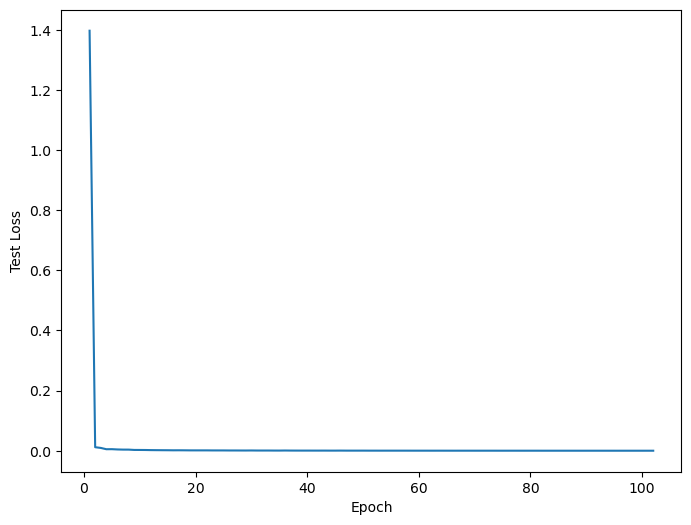

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 102), quantum_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\1820591017.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1, 101), quantum_acc_test)


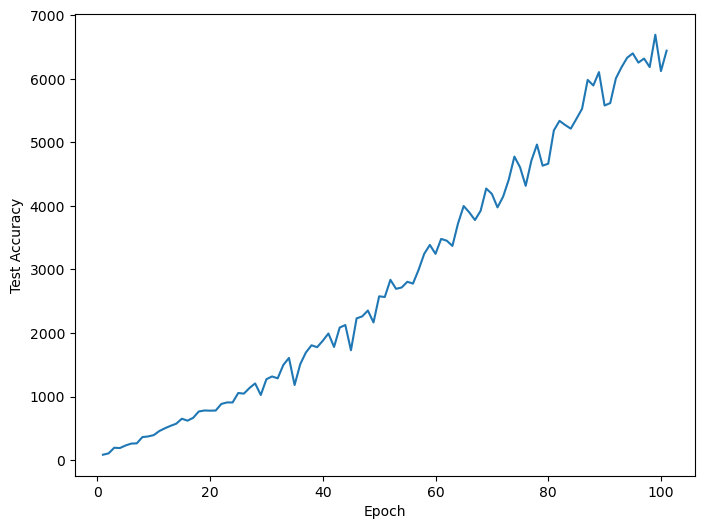

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), quantum_acc_test)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.show()

C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\596135756.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1, 101), quantum_loss_train)


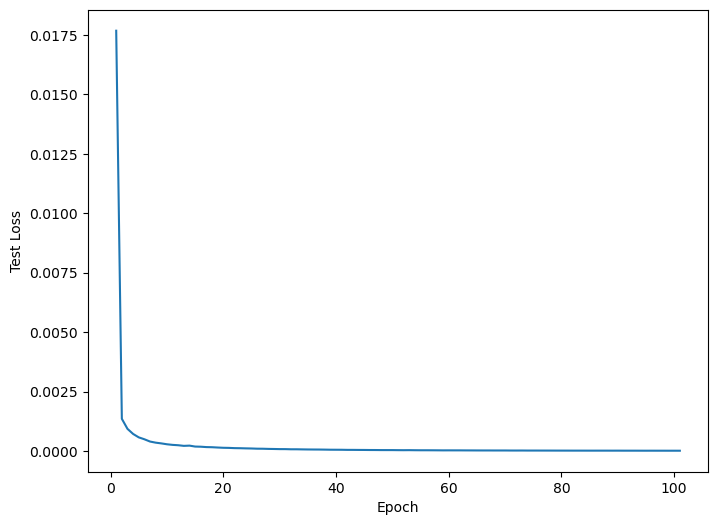

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), quantum_loss_train)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

C:\Users\uriel\AppData\Local\Temp\ipykernel_1428\1240068121.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  plt.plot(range(1, 101), quantum_acc_train)


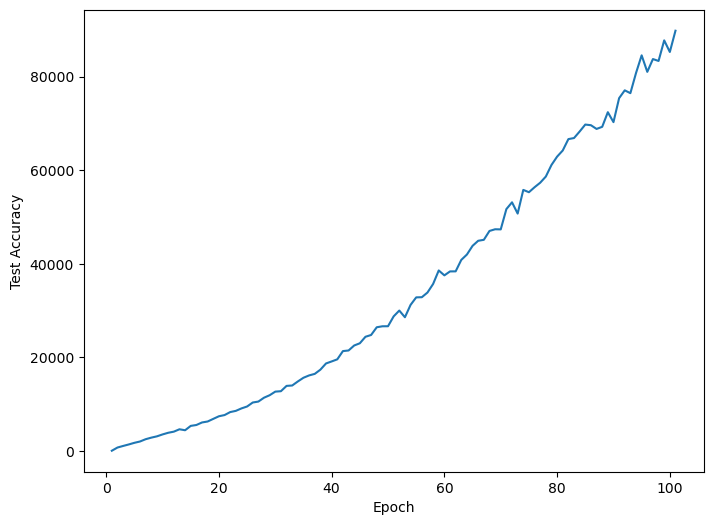

In [25]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 101), quantum_acc_train)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.show()